### Property valuation in King County (USA) using AutoML and Geo-Enriched data

### Table of Content

- [Introduction](#Introduction)
- [Necessary imports](#Necessary-Imports)
- [Accessing the King County dataset for housing prediction](#Accessing-the-King-County-dataset-for-housing-prediction)
- [Column definitions](#DataFrame-&-Definition)
- [Exploring and visualizing dataset](#Visualizing-dataset)
- [Model building using AutoML](#Model-building)
- [Data geoenrichment](#geoenrich)
- [Model building using AutoML on enriched data](#Model-Building-using-AutoML-on-Enrich-data)
- [Result visualization](#Result-Visualization)
- [Conclusion](#Conclusion)

### Introduction <a id='Introduction'></a>

Housing is considered a basic need for all human beings. Predicting housing prices can help an individual get the most out of their building, which can further help in affordability. Traditionally, appraising the value of a property entails visiting the site, valuing the features of the building, and quoting a price on the basis of prior sales, future development of the town, market knowledge, utilities, and various other things that contribute to an asset's value.

In machine learning, housing prediction is considered a regression task. Many machine learning approaches have been used to get better results. However, as more methods continue to be developed, it has become difficult for an individual to keep track of which method to use. Fortunately, AutoML helps by providing the best fit model among all available methods. In this notebook, we will use AutoML and enrich datasets to get better and quicker results, without needing to go through a series of ML algorithms.

The primary data is downloaded from the [King County](https://learngis.maps.arcgis.com/home/item.html?id=7d66f8d0adae4248a275787864be224a). Other data includes 2019 and 2017 census data using Esri's GeoEnrichment services.

### Necessary imports <a id='Necessary-Imports'></a>

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,RobustScaler,OneHotEncoder,Normalizer,StandardScaler
 
import arcgis
from arcgis.gis import GIS
from arcgis.features import GeoAccessor
from arcgis.geoenrichment import Country
from arcgis.features import summarize_data
from arcgis.features.enrich_data import enrich_layer
from arcgis.learn import prepare_tabulardata,AutoML

In [5]:
# Use your username & password to access the services
gis = GIS("home")

### Accessing the King County dataset for housing prediction <a id='Accessing-the-King-County-dataset-for-housing-prediction'></a>


First, we will create a feature layer hosted on ArcGIS Online. The dataset can either be downloaded [here](https://learngis.maps.arcgis.com/home/item.html?id=7d66f8d0adae4248a275787864be224a) or can be accessed using the item number `3e214ff4880244f08cf29595e5bc9210`.

<Item title:"kc_house_data_XYTableToPoint" type:Feature Layer Collection owner:api_data_owner>
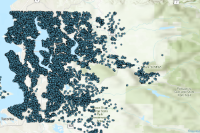

In [6]:
#the layer is already published on ArcGIS Online having item number 3e214ff4880244f08cf29595e5bc9210
King_County_Feature = gis.content.get("3e214ff4880244f08cf29595e5bc9210")
King_County_Feature

In [4]:
#selecting the first item of the content named as King_County_Feature
King_County_Feature = King_County_Feature.layers[0]

### Column definitions <a id='DataFrame-&-Definition'></a>

In [5]:
# extract the spatial dataframe from the point feature layer of King County as a pandas dataframe
sdf_kc = pd.DataFrame.spatial.from_layer(King_County_Feature)

In [14]:
# visualizing the spatial dataframe on the map 
m1 = GIS().map("Bellevue",zoomlevel=12)
sdf_kc.spatial.plot(map_widget= m1,renderer_type='s',symbol_type='simple',symbol_style='+',colors='Reds_r',cstep=10,marker_size=2)
m1

In [7]:
# to check the non null count & data types of each column
sdf_kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   OBJECTID       21613 non-null  Int64   
 1   SHAPE          21613 non-null  geometry
 2   bathrooms      21613 non-null  Float64 
 3   bedrooms       21613 non-null  Int32   
 4   condition      21613 non-null  Int32   
 5   date           21613 non-null  string  
 6   floors         21613 non-null  Float64 
 7   grade          21613 non-null  Int32   
 8   id             21613 non-null  Float64 
 9   lat            21613 non-null  Float64 
 10  long           21613 non-null  Float64 
 11  price          21613 non-null  Float64 
 12  sqft_above     21613 non-null  Int32   
 13  sqft_basement  21613 non-null  Int32   
 14  sqft_living    21613 non-null  Int32   
 15  sqft_living15  21613 non-null  Int32   
 16  sqft_lot       21613 non-null  Int32   
 17  sqft_lot15     21613 non-null  

In [8]:
# checking the first 3 rows of the dataframe
sdf_kc.head(3)

OBJECTID                                              SHAPE  bathrooms  \
0         1  {"x": -122.25699999999995, "y": 47.51120000000...        1.0   
1         2  {"x": -122.31899999999996, "y": 47.72100000000...       2.25   
2         3  {"x": -122.23299999999995, "y": 47.73790000000...        1.0   

   bedrooms  condition             date  floors  grade            id      lat  \
0         3          3  20141013T000000     1.0      7  7129300520.0  47.5112   
1         3          3  20141209T000000     2.0      7  6414100192.0   47.721   
2         2          3  20150225T000000     1.0      6  5631500400.0  47.7379   

   ...  sqft_basement  sqft_living  sqft_living15  sqft_lot  sqft_lot15  \
0  ...              0         1180           1340      5650        5650   
1  ...            400         2570           1690      7242        7639   
2  ...              0          770           2720     10000        8062   

   view_  waterfront  yr_built  yr_renovated  zipcode  
0      0           0      1955             0    98178  
1      0           0      1951          1991    98125  
2      0           0      1933             0    98028  

[3 rows x 23 columns]

The dataframe table has 20 fields describing the homes and their sale prices, along with `ObjectID` and `Shape fields`.

<table align=left>
<thead>
<tr><th align=left>Field name
</th><th align=left>Field description</th></tr>
<tbody align= left;>
<tr><td align= left;>date</td><td align= left;>Date of sale</td></tr>
<tr><td>price</td><td>Final transaction amount</td></tr>
<tr><td>bedrooms</td><td>Number of bedrooms</td></tr>
<tr><td>bathrooms</td><td>Number of bathrooms</td></tr>
<tr><td>sqft_living</td><td>Living space size (in square feet)</td></tr>
<tr><td>sqft_lot</td><td>Lot size (in square feet)</td></tr>
<tr><td>floors</td><td>Number of floors</td></tr>
<tr><td>waterfront</td><td>Is house on waterfront (1: yes, 0: not)</td></tr>
<tr><td>view</td><td>Categorical variable for view of the house</td></tr>
<tr><td>condition</td><td>Categorical variable for condition of the house</td></tr>
<tr><td>grade</td><td>Overall house grade based on King County grading system</td></tr>
<tr><td>sqft_above</td><td>Size of the house excluding basement (in square feet)</td></tr>
<tr><td>sqft_basement</td><td>Size of the basement (in square feet)</td></tr>
<tr><td>yr_built</td><td>Year house was built</td></tr>
<tr><td>yr_renovated</td><td>Year house was renovated (if renovated)</td></tr>
<tr><td>zipcode</td><td>ZIP Code of the house</td></tr>
 <tr><td>lat</td><td>Latitude of house</td></tr>
<tr><td>long</td><td>Longitude of house</td></tr>
<tr><td>sqft_living15</td><td>Size of living space in 2015 (in square feet)</td></tr>
<tr><td>sqrt_lot15</td><td>Size of lot in 2015 (in square feet)</td></tr>
</thead>

Some of the fields contain codes for specific values. These are explained below.

<table align="left" border="1">
<thead>
<tr><th>Condition
</th><th>Condition
</th><th>Description</th></tr>
</thead>
<tbody align="left">
<tr><td alig="left">1</td><td>Poor</td><td>
Many repairs needed. House is showing serious deterioration.</td></tr>
<tr><td>2</td><td>Fair</td><td>
Some repairs needed immediately. Much deferred maintenance is needed.</td></tr>
<tr><td>3</td><td>Average</td><td>
Depending upon age of improvement, normal amount of upkeep for the age of the home.</td></tr>
<tr><td>4</td><td>Good</td><td>
Condition above the norm for the age of the home. This indicates extra attention and care has been taken to maintain it.</td></tr>
<tr><td>5</td><td>Very Good</td><td>
Excellent maintenance and updating on home; not a total renovation.</td></tr>
</tbody>
</table>

<table align="left">
<thead>
<tr><th>Grade
</th><th>Description</th></tr>
</thead>
<tbody>
<tr><td>1-3</td><td>
    Falls short of minimum building standards; normally cabin or inferior structure.</td></tr>
<tr ><td>4</td><td>Generally older low quality construction. The house does not meet code.</td></tr>
<tr><td>5</td><td>Lower construction costs and workmanship. The house has small, simple design.</td></tr>
<tr><td>6</td><td>Lowest grade currently meeting building codes. Low-quality materials and simple designs were used.</td></tr>
<tr><td>7</td><td>Average grade of construction and design. This is commonly seen in plats and older subdivisions.</td></tr>
<tr><td>8</td><td>Just above average in construction and design. Houses of this quality usually have better materials in both the exterior and interior finishes.</td></tr>
<tr><td>9</td><td>Better architectural design, with extra exterior and interior design and quality.</td></tr>
<tr><td>10</td><td>Homes of this quality generally have high-quality features. Finish work is better, and more design quality is seen in the floor plans and larger square footage.</td></tr>
<tr><td>11</td><td>Custom design and higher quality finish work, with added amenities of solid woods, bathroom fixtures, and more luxurious options.</td></tr>
<tr><td>12</td><td>Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.</td></tr>
<tr><td>13</td><td>Generally custom designed and built, approaching the mansion level. These houses have a large amount of highest quality cabinet work, wood trim, and marble with large entries.</td></tr>
</tbody>
</table>

<table align="left">
<thead>
<tr><th>View
</th><th>Description</th></tr>
</thead>
<tbody>
<tr><td>0</td><td>Unknown</td></tr>
<tr><td>1</td><td>Fair</td></tr>
<tr><td>2</td><td>Average</td></tr>
<tr><td>3</td><td>Good</td></tr>
<tr><td>4</td><td>Excellent</td></tr>
</tbody>
</table>

### Exploring and visualizing dataset  <a id='Visualizing-dataset'></a>

In [9]:
# Dropping the columns such as date,id ,lat,long & OBJECTID to visualize the exploratory variables
sdf_kc_viz = sdf_kc.drop(columns=["OBJECTID", "SHAPE", "id", "date", "lat", "long"])

In [84]:
# looking into to top 3 rows of the dataframe value after dropping the columns
sdf_kc_viz.head(3)

bathrooms  bedrooms  condition  floors  grade     price  sqft_above  \
0        1.0         3          3     1.0      7  221900.0        1180   
1       2.25         3          3     2.0      7  538000.0        2170   
2        1.0         2          3     1.0      6  180000.0         770   

   sqft_basement  sqft_living  sqft_living15  sqft_lot  sqft_lot15  view_  \
0              0         1180           1340      5650        5650      0   
1            400         2570           1690      7242        7639      0   
2              0          770           2720     10000        8062      0   

   waterfront  yr_built  yr_renovated  zipcode  
0           0      1955             0    98178  
1           0      1951          1991    98125  
2           0      1933             0    98028

In [11]:
# checking if there is any NAN or null value in the dataframe
sdf_kc_viz.isnull().sum()

bathrooms        0
bedrooms         0
condition        0
floors           0
grade            0
price            0
sqft_above       0
sqft_basement    0
sqft_living      0
sqft_living15    0
sqft_lot         0
sqft_lot15       0
view_            0
waterfront       0
yr_built         0
yr_renovated     0
zipcode          0
dtype: int64

In [12]:
#let's describe the dataset for each features ranges & value
sdf_kc_viz.describe()

bathrooms      bedrooms     condition        floors         grade  \
count  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   
mean       2.114757      3.370842      3.409430      1.494309      7.656873   
std        0.770163      0.930062      0.650743      0.539989      1.175459   
min        0.000000      0.000000      1.000000      1.000000      1.000000   
25%        1.750000      3.000000      3.000000      1.000000      7.000000   
50%        2.250000      3.000000      3.000000      1.500000      7.000000   
75%        2.500000      4.000000      4.000000      2.000000      8.000000   
max        8.000000     33.000000      5.000000      3.500000     13.000000   

              price    sqft_above  sqft_basement   sqft_living  sqft_living15  \
count  2.161300e+04  21613.000000   21613.000000  21613.000000   21613.000000   
mean   5.400881e+05   1788.390691     291.509045   2079.899736    1986.552492   
std    3.671272e+05    828.090978     442.575043    918.440897     685.391304   
min    7.500000e+04    290.000000       0.000000    290.000000     399.000000   
25%    3.219500e+05   1190.000000       0.000000   1427.000000    1490.000000   
50%    4.500000e+05   1560.000000       0.000000   1910.000000    1840.000000   
75%    6.450000e+05   2210.000000     560.000000   2550.000000    2360.000000   
max    7.700000e+06   9410.000000    4820.000000  13540.000000    6210.000000   

           sqft_lot     sqft_lot15         view_    waterfront      yr_built  \
count  2.161300e+04   21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04   12768.455652      0.234303      0.007542   1971.005136   
std    4.142051e+04   27304.179631      0.766318      0.086517     29.373411   
min    5.200000e+02     651.000000      0.000000      0.000000   1900.000000   
25%    5.040000e+03    5100.000000      0.000000      0.000000   1951.000000   
50%    7.618000e+03    7620.000000      0.000000      0.000000   1975.000000   
75%    1.068800e+04   10083.000000      0.000000      0.000000   1997.000000   
max    1.651359e+06  871200.000000      4.000000      1.000000   2015.000000   

       yr_renovated       zipcode  
count  21613.000000  21613.000000  
mean      84.402258  98077.939805  
std      401.679240     53.505026  
min        0.000000  98001.000000  
25%        0.000000  98033.000000  
50%        0.000000  98065.000000  
75%        0.000000  98118.000000  
max     2015.000000  98199.000000

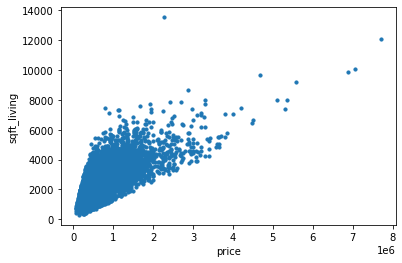

In [13]:
# scatterplot between price vs sqft_living.
sdf_kc_viz.plot.scatter(x="price", y="sqft_living", s=10);

The scatterplot indicates a positive relationship between `price` and `sqft_living`, so the larger `sqft_living` is, the more expensive the property will be.

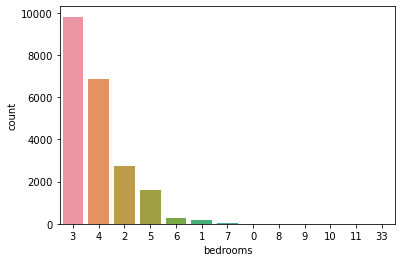

In [14]:
#countplot is plotted for the bedrooms to analyze the bedrooms capacity 
varibale = sdf_kc_viz['bedrooms'].value_counts().index
a = sdf_kc_viz.bedrooms
sns.countplot(x = sdf_kc_viz.bedrooms,order=varibale);

The graph above indicates that the most common home has 3 bedrooms.

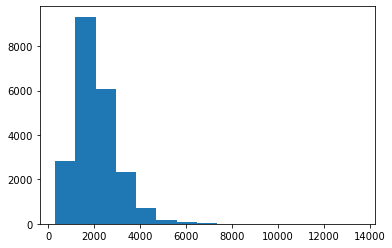

In [15]:
#A histogram is plotted for sqft living
plt.hist('sqft_living',data=sdf_kc_viz,bins=15);

The graph above has a Y-axis representing the number of bins and an X-axis representing the ranges of those bins. For example, we can see that 9,332 homes, approximately 43%, have a `sqft_living value` in the range of 1,173 - 2,056.66 sqft and that the histogram is skewed right.

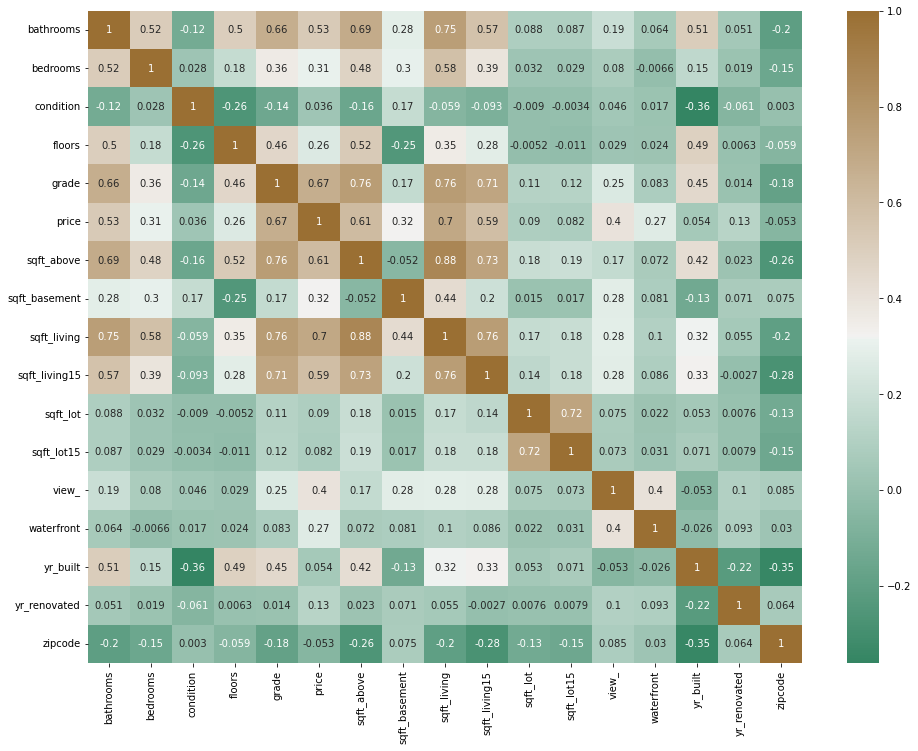

In [16]:
#heatmap plotting 
fig,ax=plt.subplots(figsize=(16,12))
colormap=sns.diverging_palette(150,50,80,as_cmap=True)
sns.heatmap(sdf_kc_viz.corr(),annot=True,cmap=colormap);

The Pearson correlation coefficient (`Pearson's r`) quantifies the strength of the linear relationship between variables, or how much influence one variable has on another. An absolute value of Pearson's r close to one indicates a strong positive linear relationship, whereas values close to zero indicate a weak linear relationship. For example, from the graph above, we can see the Pearson's r value for `price` and `sqft_living` is 0.70. This value indicates that the two variables have a strong positive relationship.

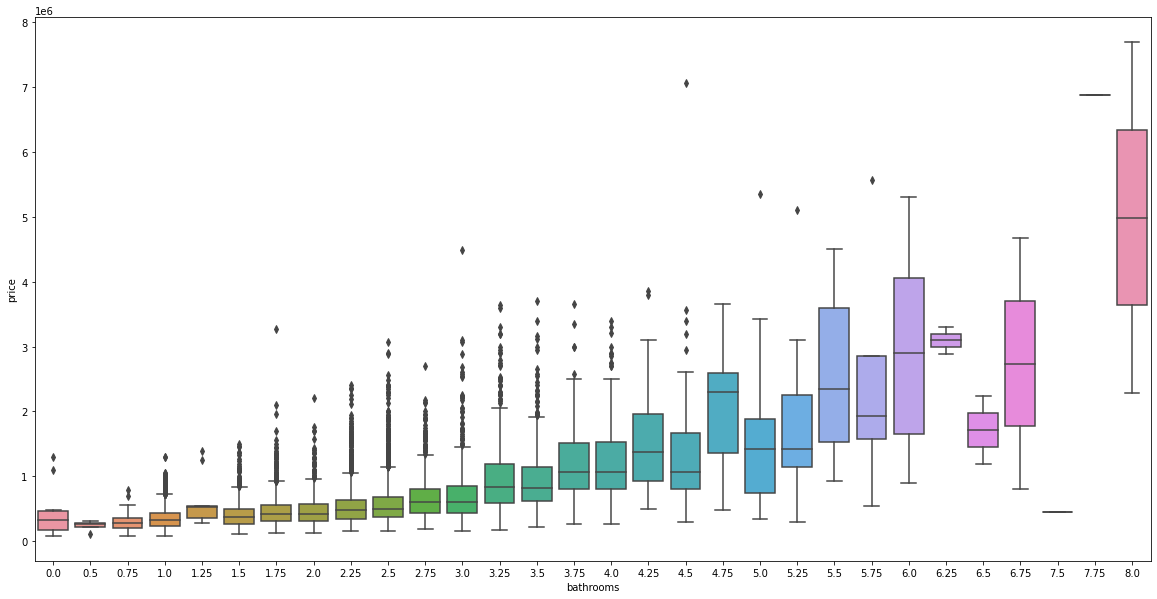

In [17]:
#boxplots
fig,ax=plt.subplots(1,1,figsize=(20,10))
sns.boxplot(x=sdf_kc_viz['bathrooms'],y=sdf_kc_viz['price']);

From the above graph, we can see that there is increasing trend in <b>prices</b> for houses with more numbers of bathroom. Houses with number of <b>bathrooms</b> less than 3 have median price value below \\$100000. In most of the cases, median value for house price lies below \\$200000 i.e. houses are available for in all the segments of <b>bathrooms</b> below the value \\$200000. Longer interquartile range is available for 5, 6, or 8 size <b>bathrooms</b> depicts that more options in valautions are available for these properties. Also, there are many outliers which indicates the variability in the house prices.

The above plots can be plotted aganist other field values such as <b>floors</b>, <b>grade</b>, <b>bedrooms</b>,etc.

### Model building using AutoML <a id='Model-building'></a>

We will use the following features in predicting home prices. Note that `Zipcode` is considered a categorical variable.

In [18]:
X = [
    "bathrooms",
    "bedrooms",
    "condition",
    "floors",
    "grade",
    "sqft_above",
    "sqft_basement",
    "sqft_living",
    "sqft_living15",
    "sqft_lot",
    "sqft_lot15",
    "view_",
    "waterfront",
    "yr_built",
    "yr_renovated",
    ("zipcode", True),
]

In [19]:
# we can use different preprocessing technique to scale our input data i.e. below RobustScaler() is used
preprocessors = [
    (
        "bathrooms",
        "bedrooms",
        "condition",
        "floors",
        "grade",
        "sqft_above",
        "sqft_basement",
        "sqft_living",
        "sqft_living15",
        "sqft_lot",
        "sqft_lot15",
        "view_",
        "waterfront",
        "yr_built",
        "yr_renovated",
        "zipcode",
        RobustScaler(),
    )
]

In [20]:
#splitting the dataset into train-test in ratio of 90%-10%.
X_train,X_test = train_test_split(sdf_kc, test_size=0.10,random_state=32, shuffle=True)

We will now create a data object by using the `prepare_tabulardata` function.(input_features=None, variable_predict=None, explanatory_variables=None, explanatory_rasters=None, date_field=None, cell_sizes=[3, 4, 5, 6, 7], distance_features=None, preprocessors=None, val_split_pct=0.1, seed=42, batch_size=64, index_field=None, working_dir=None)

In [21]:
data = prepare_tabulardata(
    X_train, "price", explanatory_variables=X,preprocessors=preprocessors)

After creating the AutoML object by passing the data obtained from `prepare_tabulardata` and using the default values for other parameters, we can train the model using AutoML. This is done by calling the fit method as shown below. A new folder will be created and all the models and their variants will be saved in that folder.

In this workflow, we are using the default perform mode i.e. 'Basic'. You could try different modes such as 'Intermediate' or 'Advanced' for better understanding of data and model performance. Results may be improved further by using different modes like `Perform` or `Compete`. To learn more about different modes, read [here](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html).

In [22]:
AutoML_class_obj = AutoML(data)
AutoML_class_obj.fit()

Neural Network algorithm was disabled because it doesn't support n_jobs parameter.
Linear algorithm was disabled.
AutoML directory: C:\Users\sum11525\AppData\Local\Temp\scratch\tmpia0ssl19
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Decision Tree', 'Random Trees', 'Extra Trees', 'LightGBM', 'Xgboost']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 1 model
1_DecisionTree rmse 251674.374595 trained in 4.16 seconds
* Step default_algorithms will try to check up to 4 models
2_Default_LightGBM rmse 142291.231133 trained in 25.94 seconds
3_Default_Xgboost rmse 138592.633225 trained in 16.66 seconds
4_Default_RandomTrees rmse 212700.052 trained in 7.75 seconds
5_Default_ExtraTrees rmse 225523.059205 trained in 5.27 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 136910.269405 trained in 0.2 seconds
AutoML fit time: 79.17 second

In [23]:
#training score represents the score generated from train dataset 
AutoML_class_obj.score()

0.9528967074504648

In [24]:
#the r-square value for the test dataset
result1 = AutoML_class_obj.predict(X_test,prediction_type="dataframe")
print(r2_score(result1[['price']], result1[['prediction_results']]))

0.8466806852435925


C:\Users\sum11525\AppData\Local\ESRI\conda\envs\dl_env\lib\site-packages\sklearn\metrics\_regression.py:95: FutureWarning:

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.



### Data geo-enrichment <a id='geoenrich'></a>

We will now enrich our data using the [GeoEnrichment](https://developers.arcgis.com/rest/geoenrichment/api-reference/geoenrichment-service-overview.htm) services from Esri that contains the latest census data.
The entire data repository is first visualized, out of which the relevant variables are finalized from a literature study. These selected variables are searched for adding in the feature set.

In [25]:
# Displaying the various data topic available for GeoEnrichment for USA in the Esri database
usa = Country.get("US")
usa_data = usa.data_collections
df_usa_data = pd.DataFrame(usa_data)
df_usa_data.head(3)

analysisVariable                   alias  \
dataCollectionID                                                    
1yearincrements   1yearincrements.AGE0_CY  2022 Population Age <1   
1yearincrements   1yearincrements.AGE1_CY   2022 Population Age 1   
1yearincrements   1yearincrements.AGE2_CY   2022 Population Age 2   

                                       fieldCategory vintage  
dataCollectionID                                              
1yearincrements   2022 Age: 1 Year Increments (Esri)    2022  
1yearincrements   2022 Age: 1 Year Increments (Esri)    2022  
1yearincrements   2022 Age: 1 Year Increments (Esri)    2022

In [26]:
# Filtering the unique topic under dataCollectionID
df_usa_data.reset_index(inplace=True)
list(df_usa_data.dataCollectionID.unique())

['1yearincrements',
 '5yearincrements',
 'Age',
 'agebyracebysex',
 'AgeDependency',
 'AtRisk',
 'AutomobilesAutomotiveProducts',
 'BabyProductsToysGames',
 'basicFactsForMobileApps',
 'businesses',
 'CivicActivitiesPoliticalAffiliation',
 'classofworker',
 'clothing',
 'ClothingShoesAccessories',
 'commute',
 'crime',
 'DaytimePopulation',
 'disability',
 'disposableincome',
 'DniRates',
 'education',
 'educationalattainment',
 'ElectronicsInternet',
 'employees',
 'EmploymentUnemployment',
 'entertainment',
 'financial',
 'FinancialInsurance',
 'food',
 'foodstampsSNAP',
 'gender',
 'Generations',
 'GroceryAlcoholicBeverages',
 'groupquarters',
 'Health',
 'healthinsurancecoverage',
 'HealthPersonalCare',
 'HealthPersonalCareCEX',
 'heatingfuel',
 'hispanicorigin',
 'HistoricalHouseholds',
 'HistoricalHousing',
 'HistoricalPopulation',
 'HomeImprovementGardenLawn',
 'homevalue',
 'HouseholdGoodsFurnitureAppliances',
 'householdincome',
 'households',
 'householdsbyageofhouseholder',


Items can be searched using the alias field. For example, we can search the alias field for the term `Nonprofit`.

In [27]:
df_usa_data[df_usa_data["alias"].str.contains("Nonprofit")]

dataCollectionID          analysisVariable  \
3086    classofworker  classofworker.ACSMPRIVNP   
3087    classofworker  classofworker.MOEMPRIVNP   
3094    classofworker  classofworker.RELMPRIVNP   
3119    classofworker  classofworker.ACSFPRIVNP   
3120    classofworker  classofworker.MOEFPRIVNP   
3121    classofworker  classofworker.RELFPRIVNP   

                                                  alias  \
3086        2020 Civ Male 16+:Priv Nonprofit (ACS 5-Yr)   
3087    2020 Civ Male 16+:Priv Nonprofit MOE (ACS 5-Yr)   
3094    2020 Civ Male 16+:Priv Nonprofit REL (ACS 5-Yr)   
3119      2020 Civ Female 16+:Priv Nonprofit (ACS 5-Yr)   
3120  2020 Civ Female 16+:Priv Nonprofit MOE (ACS 5-Yr)   
3121  2020 Civ Female 16+:Priv Nonprofit REL (ACS 5-Yr)   

                        fieldCategory    vintage  
3086  2016-2020 Class of Worker (ACS)  2016-2020  
3087  2016-2020 Class of Worker (ACS)  2016-2020  
3094  2016-2020 Class of Worker (ACS)  2016-2020  
3119  2016-2020 Class of Worker (ACS)  2016-2020  
3120  2016-2020 Class of Worker (ACS)  2016-2020  
3121  2016-2020 Class of Worker (ACS)  2016-2020

Adding data using enrichment - At this stage, a literature study is undertaken to narrow down the various factors that might impact the price of a home in King County.

Subsequently these factors are identified from the USA GeoEnrichment database, as shown above. These variable names are then compiled in a dictionary to pass to the enrichment tool.

Adding each geoenrichment variable will cost extra credits for the user, and they will have to pay the associated charges.

In [35]:
enrichment_variables = {
    "classofworker.ACSCIVEMP": "Employed Population Age 16+",
    "classofworker.ACSMCIVEMP": "Employed Male Pop Age 16+",
    "classofworker.ACSMPRIVNP": "Male 16+Priv Nonprofit",
    "classofworker.ACSMEPRIVP": "Male 16+:Priv Profit Empl",
    "classofworker.ACSMSELFI": "Male 16+:Priv Profit Self Empl",
    "classofworker.ACSMSTGOV": "Male 16+:State Govt Wrkr",
    "classofworker.ACSMFEDGOV": "Male 16+:Fed Govt Wrkr",
    "classofworker.ACSMSELFNI": "Male 16+:Self-Emp Not Inc",
    "classofworker.ACSMUNPDFM": "Male 16+:Unpaid Family Wrkr",
    "classofworker.ACSFCIVEMP": "Female Pop Age 16+",
    "classofworker.ACSFEPRIVP": "Female 16+:Priv Profit Empl",
    "classofworker.ACSFSELFI": "Female 16+:Priv Profit Self Empl",
    "classofworker.ACSFPRIVNP": "Female 16+:Priv Nonprofit",
    "classofworker.ACSFLOCGOV": "Female 16+:Local Govt Wrkr",
    "classofworker.ACSFSTGOV": "Female 16+:State Govt Wrkr",
    "classofworker.ACSFFEDGOV": "Female 16+:Fed Govt Wrkr",
    "classofworker.ACSFSELFNI": "Female 16+:Self-Emp Not Inc",
    "classofworker.ACSFUNPDFM": "Female 16+:Unpaid Family Wrkr",
    "gender.MEDAGE_CY": "2019 Median Age",
    "Generations.GENALPHACY": "2019 Generation Alpha Population",
    "Generations.GENZ_CY": "2019 Generation Z Population",
    "Generations.MILLENN_CY": "2019 Millennial Population",
    "Generations.GENX_CY": "2019 Generation X Population",
    "Generations.BABYBOOMCY": "2019 Baby Boomer Population",
    "Generations.OLDRGENSCY": "2019 Silent & Greatest Generations Population",
    "Generations.GENBASE_CY": "2019 Population by Generation Base",
    "populationtotals.POPDENS_CY": "2019 Population Density",
    "DaytimePopulation.DPOP_CY": "2019 Total Daytime Population",
    "raceandhispanicorigin.WHITE_CY": "2019 White Population",
    "raceandhispanicorigin.BLACK_CY": "2019 Black Population",
    "raceandhispanicorigin.AMERIND_CY": "2019 American Indian Population",
    "raceandhispanicorigin.ASIAN_CY": "2019 Asian Population",
    "raceandhispanicorigin.PACIFIC_CY": "2019 Pacific Islander Population",
    "raceandhispanicorigin.OTHRACE_CY": "2019 Other Race Population",
    "raceandhispanicorigin.DIVINDX_CY": "2019 Diversity Index",
    "households.ACSHHBPOV": "HHs: Inc Below Poverty Level",
    "households.ACSHHAPOV": "HHs:Inc at/Above Poverty Level",
    "businesses.S01_BUS": "Total Businesses (SIC)",
    "businesses.N05_BUS": "Construction Businesses (NAICS)",
    "businesses.N08_BUS": "Retail Trade Businesses (NAICS)",
    "businesses.N21_BUS": "Transportation/Warehouse Bus (NAICS)",
    "ElectronicsInternet.MP09147a_B": "Own any tablet",
    "ElectronicsInternet.MP09148a_B": "Own any e-reader",
    "ElectronicsInternet.MP19001a_B": "Have access to Internet at home",
    "ElectronicsInternet.MP19070a_I": "Index: Spend 0.5-0.9 hrs online(excl email/IM .",
    "ElectronicsInternet.MP19071a_B": "Spend <0.5 hrs online (excl email/IM time) daily",
    "populationtotals.TOTPOP_CY": "2019 Total Population",
    "gender.MALES_CY": "2019 Male Population",
    "gender.FEMALES_CY": "2019 Female Population",
    "industry.EMP_CY": "2019 Employed Civilian Pop 16+",
    "industry.UNEMP_CY": "2019 Unemployed Population 16+",
    "industry.UNEMPRT_CY": "2019 Unemployment Rate",
    "commute.ACSWORKERS": "ACS Workers Age 16+",
    "commute.ACSDRALONE": "ACS Workers 16+: Drove Alone",
    "commute.ACSCARPOOL": "ACS Workers 16+: Carpooled",
    "commute.ACSPUBTRAN": "ACS Workers 16+: Public Transportation",
    "commute.ACSBUS": "ACS Workers 16+: Bus",
    "commute.ACSSTRTCAR": "ACS Workers 16+: Streetcar",
    "commute.ACSSUBWAY": "ACS Workers 16+: Subway",
    "commute.ACSFERRY": "ACS Workers 16+: Ferryboat",
    "commute.ACSTAXICAB": "ACS Workers 16+: Taxicab",
    "commute.ACSMCYCLE": "ACS Workers 16+: Motorcycle",
    "commute.ACSBICYCLE": "ACS Workers 16+: Bicycle",
    "commute.ACSWALKED": "ACS Workers 16+: Walked",
    "commute.ACSOTHTRAN": "ACS Workers 16+: Other Means",
    "commute.ACSWRKHOME": "ACS Wrkrs 16+: Worked at Home",
    "OwnerRenter.OWNER_CY": "2019 Owner Occupied HUs",
    "OwnerRenter.RENTER_CY": "2019 Renter Occupied HUs",
    "vacant.VACANT_CY": "2019 Vacant Housing Units",
    "homevalue.MEDVAL_CY": "2019 Median Home Value",
    "housingunittotals.TOTHU_CY": "2019 Total Housing Units",
    "yearbuilt.ACSMEDYBLT": "ACS Median Year Structure Built: HUs",
    "SpendingTotal.X1001_X": "2019 Annual Budget Exp",
    "transportation.X6001_X": "2019 Transportation",
    "DaytimePopulation.DPOPWRK_CY": "2019 Daytime Pop: Workers",
    "DaytimePopulation.DPOPRES_CY": "2019 Daytime Pop: Residents",
    "DaytimePopulation.DPOPDENSCY": "2019 Daytime Pop Density",
    "occupation.OCCPROT_CY": "2019 Occupation: Protective Service",
    "occupation.OCCFOOD_CY": "2019 Occupation: Food Preperation",
    "occupation.OCCPERS_CY": "2019 Occupation: Personal Care",
    "occupation.OCCADMN_CY": "2019 Occupation: Office/Admin",
    "occupation.OCCCONS_CY": "2019 Occupation: Construction/Extraction",
    "occupation.OCCPROD_CY": "2019 Occupation: Production",
}

In [36]:
# Enrichment operation using ArcGIS API for Python
enrichment_variables_df = pd.DataFrame.from_dict(
    enrichment_variables, orient="index", columns=["Variable Definition"]
)
enrichment_variables_df.reset_index(level=0, inplace=True)
enrichment_variables_df.columns = ["AnalysisVariable", "Variable Definition"]
enrichment_variables_df.head(3)

AnalysisVariable          Variable Definition
0   classofworker.ACSCIVEMP  Employed Population Age 16+
1  classofworker.ACSMCIVEMP    Employed Male Pop Age 16+
2  classofworker.ACSMPRIVNP       Male 16+Priv Nonprofit

In [37]:
# Convertng the variables names to list for passing them to the enrichment tool
variable_names = enrichment_variables_df["AnalysisVariable"].tolist()

# checking the firt few values of the list
variable_names[0:5]

['classofworker.ACSCIVEMP',
 'classofworker.ACSMCIVEMP',
 'classofworker.ACSMPRIVNP',
 'classofworker.ACSMEPRIVP',
 'classofworker.ACSMSELFI']

Data enriching operation: See the <a href="https://developers.arcgis.com/python/api-reference/arcgis.features.enrich_data.html" target="_blank"> enrich_layer method </a> documentation for more information.

In [68]:
# we are using buffer distance of 3 miles in straightline as it is point feature in our use case
from datetime import datetime
now = datetime.now() # current date and time
#adding timestamp to output_file_name 
output_file_name = "enrhcied_kc_" + now.strftime("%m%d%Y%H%M%S")
King_County_Feature_enriched = enrich_layer(
    King_County_Feature,
    buffer_type="StraightLine",
    distance=3.0,
    units="Miles",
    analysis_variables=variable_names,
    output_name=output_file_name,
)

In [69]:
# Extracting the resulting enriched dataframe after the geoenrichment method
sdf_King_County_Feature_enriched = King_County_Feature_enriched.layers[0].query().sdf

In [70]:
# Visualizing the pandas dataframe columns
print(sdf_King_County_Feature_enriched.columns)

Index(['OBJECTID', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront',
       ...
       'DPOPWRK_CY', 'DPOPRES_CY', 'DPOPDENSCY', 'OCCPROT_CY', 'OCCFOOD_CY',
       'OCCPERS_CY', 'OCCADMN_CY', 'OCCCONS_CY', 'OCCPROD_CY', 'SHAPE'],
      dtype='object', length=117)


The field names of the enriched dataframe are coded terms that will need to be edited. Rename these fields with their actual definition from the variable definition of the list that was first created during selection of the variables.

In [71]:
enrichment_variables_df.head(3)

AnalysisVariable          Variable Definition
0   classofworker.ACSCIVEMP  Employed Population Age 16+
1  classofworker.ACSMCIVEMP    Employed Male Pop Age 16+
2  classofworker.ACSMPRIVNP       Male 16+Priv Nonprofit

In [72]:
enrichment_variables_copy = enrichment_variables_df.copy()
enrichment_variables_copy.head(3)

AnalysisVariable          Variable Definition
0   classofworker.ACSCIVEMP  Employed Population Age 16+
1  classofworker.ACSMCIVEMP    Employed Male Pop Age 16+
2  classofworker.ACSMPRIVNP       Male 16+Priv Nonprofit

In [73]:
enrichment_variables_copy["AnalysisVariable"] = enrichment_variables_copy.AnalysisVariable.str.split(pat=".", expand=True)[1]
enrichment_variables_copy

AnalysisVariable                       Variable Definition
0         ACSCIVEMP               Employed Population Age 16+
1        ACSMCIVEMP                 Employed Male Pop Age 16+
2        ACSMPRIVNP                    Male 16+Priv Nonprofit
3        ACSMEPRIVP                 Male 16+:Priv Profit Empl
4         ACSMSELFI            Male 16+:Priv Profit Self Empl
..              ...                                       ...
78       OCCFOOD_CY         2019 Occupation: Food Preperation
79       OCCPERS_CY            2019 Occupation: Personal Care
80       OCCADMN_CY             2019 Occupation: Office/Admin
81       OCCCONS_CY  2019 Occupation: Construction/Extraction
82       OCCPROD_CY               2019 Occupation: Production

[83 rows x 2 columns]

In [74]:
enrichment_variables_copy.set_index("AnalysisVariable", drop=True, inplace=True)
dictionary = enrichment_variables_copy.to_dict()
new_columns = dictionary["Variable Definition"]

In [75]:
# setting the columns to greater value i.e 150 as to get all the columns of the data frame
pd.set_option("display.max_columns", 150)

# Field renamed and new dataframe visualized
sdf_King_County_Feature_enriched.rename(columns=new_columns, inplace=True)
sdf_King_County_Feature_enriched.head(3)

OBJECTID            id             date     price  bedrooms  bathrooms  \
0         1  7129300520.0  20141013T000000  221900.0         3        1.0   
1         2  6414100192.0  20141209T000000  538000.0         3       2.25   
2         3  5631500400.0  20150225T000000  180000.0         2        1.0   

   sqft_living  sqft_lot  floors  waterfront  view_  condition  grade  \
0         1180      5650     1.0           0      0          3      7   
1         2570      7242     2.0           0      0          3      7   
2          770     10000     1.0           0      0          3      6   

   sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  \
0        1180              0      1955             0    98178  47.5112   
1        2170            400      1951          1991    98125   47.721   
2         770              0      1933             0    98028  47.7379   

      long  sqft_living15  sqft_lot15 ID_1 sourceCountry  ENRICH_FID  \
0 -122.257           1340        5650    0            US           1   
1 -122.319           1690        7639    1            US           2   
2 -122.233           2720        8062    2            US           3   

     areaType bufferUnits bufferUnitsAlias  bufferRadii  \
0  RingBuffer   esriMiles            Miles          3.0   
1  RingBuffer   esriMiles            Miles          3.0   
2  RingBuffer   esriMiles            Miles          3.0   

                                   aggregationMethod  \
0  BlockApportionment:US.BlockGroups;PointsLayer:...   
1  BlockApportionment:US.BlockGroups;PointsLayer:...   
2  BlockApportionment:US.BlockGroups;PointsLayer:...   

   populationToPolygonSizeRating  apportionmentConfidence  HasData  \
0                          2.191                    2.576        1   
1                          2.191                    2.576        1   
2                          2.191                    2.576        1   

   Employed Population Age 16+  Employed Male Pop Age 16+  \
0                      57466.0                    30569.0   
1                     101406.0                    52042.0   
2                      60330.0                    33483.0   

   Male 16+Priv Nonprofit  Male 16+:Priv Profit Empl  \
0                  1897.0                    21145.0   
1                  4242.0                    35411.0   
2                  1625.0                    26271.0   

   Male 16+:Priv Profit Self Empl  Male 16+:State Govt Wrkr  \
0                          1545.0                    1200.0   
1                          2470.0                    3027.0   
2                          1360.0                    1018.0   

   Male 16+:Fed Govt Wrkr  Male 16+:Self-Emp Not Inc  \
0                   746.0                     2254.0   
1                  1294.0                     3044.0   
2                   339.0                     1792.0   

   Male 16+:Unpaid Family Wrkr  Female Pop Age 16+  \
0                         66.0             26898.0   
1                         26.0             49365.0   
2                         60.0             26847.0   

   Female 16+:Priv Profit Empl  Female 16+:Priv Profit Self Empl  \
0                      15636.0                             763.0   
1                      27950.0                            1530.0   
2                      17244.0                             942.0   

   Female 16+:Priv Nonprofit  Female 16+:Local Govt Wrkr  \
0                     4245.0                      2061.0   
1                     8461.0                      2997.0   
2                     3015.0                      1845.0   

   Female 16+:State Govt Wrkr  Female 16+:Fed Govt Wrkr  \
0                      1792.0                     626.0   
1                      4256.0                     868.0   
2                      1540.0                     337.0   

   Female 16+:Self-Emp Not Inc  Female 16+:Unpaid Family Wrkr  \
0                       1726.0                           49.0   
1                       32

The renamed dataframe can now be more easily interpreted.

### Model building using AutoML on enriched data <a id='Model-Building-using-AutoML-on-Enrich-data'></a>

Next we will fit the Enriched dataset into AutoML to get a better output.

In [76]:
X = ['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view_',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 ('zipcode', True),
 'sqft_living15',
 'sqft_lot15',
 'Employed Population Age 16+',
 'Employed Male Pop Age 16+',
 'Male 16+Priv Nonprofit',
 'Male 16+:Priv Profit Empl',
 'Male 16+:Priv Profit Self Empl',
 'Male 16+:State Govt Wrkr',
 'Male 16+:Fed Govt Wrkr',
 'Male 16+:Self-Emp Not Inc',
 'Male 16+:Unpaid Family Wrkr',
 'Female Pop Age 16+',
 'Female 16+:Priv Profit Empl',
 'Female 16+:Priv Profit Self Empl',
 'Female 16+:Priv Nonprofit',
 'Female 16+:Local Govt Wrkr',
 'Female 16+:State Govt Wrkr',
 'Female 16+:Fed Govt Wrkr',
 'Female 16+:Self-Emp Not Inc',
 'Female 16+:Unpaid Family Wrkr',
 '2019 Median Age',
 '2019 Generation Alpha Population',
 '2019 Generation Z Population',
 '2019 Millennial Population',
 '2019 Generation X Population',
 '2019 Baby Boomer Population',
 '2019 Silent & Greatest Generations Population',
 '2019 Population by Generation Base',
 '2019 Population Density',
 '2019 Total Daytime Population',
 '2019 White Population',
 '2019 Black Population',
 '2019 American Indian Population',
 '2019 Asian Population',
 '2019 Pacific Islander Population',
 '2019 Other Race Population',
 '2019 Diversity Index',
 'HHs: Inc Below Poverty Level',
 'HHs:Inc at/Above Poverty Level',
 'Total Businesses (SIC)',
 'Construction Businesses (NAICS)',
 'Retail Trade Businesses (NAICS)',
 'Transportation/Warehouse Bus (NAICS)',
 'Own any tablet',
 'Own any e-reader',
 'Have access to Internet at home',
 'Index: Spend 0.5-0.9 hrs online(excl email/IM .',
 'Spend <0.5 hrs online (excl email/IM time) daily',
 '2019 Total Population',
 '2019 Male Population',
 '2019 Female Population',
 '2019 Employed Civilian Pop 16+',
 '2019 Unemployed Population 16+',
 '2019 Unemployment Rate',
 'ACS Workers Age 16+',
 'ACS Workers 16+: Drove Alone',
 'ACS Workers 16+: Carpooled',
 'ACS Workers 16+: Public Transportation',
 'ACS Workers 16+: Bus',
 'ACS Workers 16+: Streetcar',
 'ACS Workers 16+: Subway',
 'ACS Workers 16+: Ferryboat',
 'ACS Workers 16+: Taxicab',
 'ACS Workers 16+: Motorcycle',
 'ACS Workers 16+: Bicycle',
 'ACS Workers 16+: Walked',
 'ACS Workers 16+: Other Means',
 'ACS Wrkrs 16+: Worked at Home',
 '2019 Owner Occupied HUs',
 '2019 Renter Occupied HUs',
 '2019 Vacant Housing Units',
 '2019 Median Home Value',
 '2019 Total Housing Units',
 'ACS Median Year Structure Built: HUs',
 '2019 Annual Budget Exp',
 '2019 Transportation',
 '2019 Daytime Pop: Workers',
 '2019 Daytime Pop: Residents',
 '2019 Daytime Pop Density',
 '2019 Occupation: Protective Service',
 '2019 Occupation: Food Preperation',
 '2019 Occupation: Personal Care',
 '2019 Occupation: Office/Admin',
 '2019 Occupation: Construction/Extraction',
 '2019 Occupation: Production']

In [77]:
preprocessors = [
    (
        "bedrooms",
        "bathrooms",
        "sqft_living",
        "sqft_lot",
        "floors",
        "waterfront",
        "view_",
        "condition",
        "grade",
        "sqft_above",
        "sqft_basement",
        "yr_built",
        "yr_renovated",
        "zipcode",
        "sqft_living15",
        "sqft_lot15",
        "Employed Population Age 16+",
        "Employed Male Pop Age 16+",
        "Male 16+Priv Nonprofit",
        "Male 16+:Priv Profit Empl",
        "Male 16+:Priv Profit Self Empl",
        "Male 16+:State Govt Wrkr",
        "Male 16+:Fed Govt Wrkr",
        "Male 16+:Self-Emp Not Inc",
        "Male 16+:Unpaid Family Wrkr",
        "Female Pop Age 16+",
        "Female 16+:Priv Profit Empl",
        "Female 16+:Priv Profit Self Empl",
        "Female 16+:Priv Nonprofit",
        "Female 16+:Local Govt Wrkr",
        "Female 16+:State Govt Wrkr",
        "Female 16+:Fed Govt Wrkr",
        "Female 16+:Self-Emp Not Inc",
        "Female 16+:Unpaid Family Wrkr",
        "2019 Median Age",
        "2019 Generation Alpha Population",
        "2019 Generation Z Population",
        "2019 Millennial Population",
        "2019 Generation X Population",
        "2019 Baby Boomer Population",
        "2019 Silent & Greatest Generations Population",
        "2019 Population by Generation Base",
        "2019 Population Density",
        "2019 Total Daytime Population",
        "2019 White Population",
        "2019 Black Population",
        "2019 American Indian Population",
        "2019 Asian Population",
        "2019 Pacific Islander Population",
        "2019 Other Race Population",
        "2019 Diversity Index",
        "HHs: Inc Below Poverty Level",
        "HHs:Inc at/Above Poverty Level",
        "Total Businesses (SIC)",
        "Construction Businesses (NAICS)",
        "Retail Trade Businesses (NAICS)",
        "Transportation/Warehouse Bus (NAICS)",
        "Own any tablet",
        "Own any e-reader",
        "Have access to Internet at home",
        "Index: Spend 0.5-0.9 hrs online(excl email/IM .",
        "Spend <0.5 hrs online (excl email/IM time) daily",
        "2019 Total Population",
        "2019 Male Population",
        "2019 Female Population",
        "2019 Employed Civilian Pop 16+",
        "2019 Unemployed Population 16+",
        "2019 Unemployment Rate",
        "ACS Workers Age 16+",
        "ACS Workers 16+: Drove Alone",
        "ACS Workers 16+: Carpooled",
        "ACS Workers 16+: Public Transportation",
        "ACS Workers 16+: Bus",
        "ACS Workers 16+: Streetcar",
        "ACS Workers 16+: Subway",
        "ACS Workers 16+: Ferryboat",
        "ACS Workers 16+: Taxicab",
        "ACS Workers 16+: Motorcycle",
        "ACS Workers 16+: Bicycle",
        "ACS Workers 16+: Walked",
        "ACS Workers 16+: Other Means",
        "ACS Wrkrs 16+: Worked at Home",
        "2019 Owner Occupied HUs",
        "2019 Renter Occupied HUs",
        "2019 Vacant Housing Units",
        "2019 Median Home Value",
        "2019 Total Housing Units",
        "ACS Median Year Structure Built: HUs",
        "2019 Annual Budget Exp",
        "2019 Transportation",
        "2019 Daytime Pop: Workers",
        "2019 Daytime Pop: Residents",
        "2019 Daytime Pop Density",
        "2019 Occupation: Protective Service",
        "2019 Occupation: Food Preperation",
        "2019 Occupation: Personal Care",
        "2019 Occupation: Office/Admin",
        "2019 Occupation: Construction/Extraction",
        "2019 Occupation: Production",
        RobustScaler(),
    )
]

In [78]:
from sklearn.model_selection import train_test_split
X_train,X_test = train_test_split(sdf_King_County_Feature_enriched, test_size=0.1,random_state=32, shuffle=True)

In [79]:
data = prepare_tabulardata(X_train,
                           'price',
                           explanatory_variables=X,                           
                           preprocessors=preprocessors)

In [80]:
AutoML_class_obj2 = AutoML(data=data,eval_metric = "r2")
AutoML_class_obj2.fit()

Neural Network algorithm was disabled because it doesn't support n_jobs parameter.
Linear algorithm was disabled.
AutoML directory: C:\Users\sum11525\AppData\Local\Temp\scratch\tmp349ystyn
The task is regression with evaluation metric r2
AutoML will use algorithms: ['Decision Tree', 'Random Trees', 'Extra Trees', 'LightGBM', 'Xgboost']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 1 model
1_DecisionTree r2 0.618045 trained in 7.7 seconds
* Step default_algorithms will try to check up to 4 models
2_Default_LightGBM r2 0.907523 trained in 39.34 seconds
Exception while producing SHAP explanations. feature_names must be string, and may not contain [, ] or <
Continuing ...
3_Default_Xgboost r2 0.906359 trained in 34.3 seconds
4_Default_RandomTrees r2 0.780248 trained in 30.21 seconds
5_Default_ExtraTrees r2 0.756224 trained in 16.2 seconds
* Step ensemble will try to check up to 1 m

In [81]:
#Training score r-square value 
AutoML_class_obj2.score()

0.9661313207543829

In [83]:
#test dataset r-square value 
result1 = AutoML_class_obj2.predict(X_test,prediction_type="dataframe")
r2_score(result1[['price']], result1[['prediction_results']])

C:\Users\sum11525\AppData\Local\ESRI\conda\envs\dl_env\lib\site-packages\arcgis\learn\models\_auto_ml.py:982: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\sum11525\AppData\Local\ESRI\conda\envs\dl_env\lib\site-packages\sklearn\metrics\_regression.py:95: FutureWarning:

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.



0.8958620896732459

AutoML_class_obj2.save('< Pass the path >') can be used to save the model at desired path.

### Result visualization <a id='Result-Visualization'></a>

In [35]:
# report regarding the model generated
AutoML_class_obj2.report()

C:\Users\sum11525\AppData\Local\ESRI\conda\envs\dl_env\lib\site-packages\arcgis\learn\models\_auto_ml.py:353: UserWarning:

In case the report html is not rendered appropriately in the notebook, the same can be found in the path C:\Users\sum11525\AppData\Local\Temp\scratch\tmppe8kfn_w\README.html



In [36]:
#the visualize the result
AutoML_class_obj2.show_results()

C:\Users\sum11525\AppData\Local\ESRI\conda\envs\dl_env\lib\site-packages\arcgis\learn\models\_auto_ml.py:329: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



2019 American Indian Population  2019 Annual Budget Exp  \
3491                            3774.0           17562184017.0   
16606                           3449.0           41599208834.0   
18896                           3201.0           37562183896.0   
18987                           3656.0           13895987208.0   
19914                           3151.0           20060715178.0   

       2019 Asian Population  2019 Baby Boomer Population  \
3491                 77917.0                      70545.0   
16606                98537.0                     101116.0   
18896                85175.0                      88016.0   
18987                73220.0                      63034.0   
19914                66547.0                      59948.0   

       2019 Black Population  2019 Daytime Pop Density  \
3491                 47063.0                    5461.6   
16606                26447.0                    9123.1   
18896                23091.0                    8851.0   
18987                45937.0                    4267.8   
19914                30877.0                    6390.7   

       2019 Daytime Pop: Residents  2019 Daytime Pop: Workers  \
3491                      167102.0                   261787.0   
16606                     226335.0                   490084.0   
18896                     195548.0                   499501.0   
18987                     153180.0                   181966.0   
19914                     132123.0                   369730.0   

       2019 Diversity Index  2019 Employed Civilian Pop 16+  \
3491                   77.1                        192440.0   
16606                  60.7                        355667.0   
18896                  60.3                        322581.0   
18987                  80.2                        169880.0   
19914                  71.8                        190650.0   

       2019 Female Population  2019 Generation Alpha Population  \
3491                 178997.0                           23789.0   
16606                287832.0                           27112.0   
18896                254803.0                           23252.0   
18987                161143.0                           23464.0   
19914                158511.0                           16922.0   

       2019 Generation X Population  2019 Generation Z Population  \
3491                        76106.0                       74651.0   
16606                      112130.0                      110861.0   
18896                      100662.0                       97909.0   
18987                       68020.0                       68552.0   
19914                       66277.0                       54320.0   

       2019 Male Population  2019 Median Age  2019 Median Home Value  \
3491               178375.0             39.6                694635.0   
16606              290803.0             37.0                873361.0   
18896              260527.0             36.8                880079.0   
18987              158983.0             39.3                643700.0   
19914              162649.0             38.8                724144.0   

       2019 Millennial Population  2019 Occupation: Construction/Extraction  \
3491                      92556.0                                    7046.0   
16606                    198874.0                                    5546.0   
18896                    181263.0                                    4517.0   
18987                     80638.0                                    7874.0   
19914                    105833.0                                    4809.0   

       2019 Occupation: Food Preperation  2019 Occupation: Office/Admin  \
3491                             13578.0                        16444.0   
16606                            17998.0                        23893.0   
18896                            17162.0                        21486.0   
18987                            12050.0                        15413.0   
19914                  

In [63]:
#prediction on the test dataset
result1 = AutoML_class_obj.predict(X_test,prediction_type="dataframe")
result1.head()

C:\Users\sum11525\AppData\Local\ESRI\conda\envs\dl_env\lib\site-packages\arcgis\learn\models\_auto_ml.py:982: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



OBJECTID            id             date     price  bedrooms  bathrooms  \
13985     13986  2591010180.0  20140709T000000  379000.0         3        2.5   
20840     20841  3438500253.0  20140904T000000  616950.0         5        3.5   
3340       3341  6403510090.0  20141111T000000  437500.0         4        2.5   
12388     12389  3935900232.0  20140929T000000  207000.0         3        1.0   
6347       6348  5608000840.0  20140724T000000  905000.0         4        2.5   

       sqft_living  sqft_lot  floors  waterfront  view_  condition  grade  \
13985         1530      2913     2.0           0      0          4      7   
20840         3560      5008     2.0           0      0          3      8   
3340          2680      7513     2.0           0      0          3      8   
12388          920      5546     1.0           0      0          2      6   
6347          3520     12193     2.0           0      0          4     10   

       sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  \
13985        1530              0      1986             0    98033  47.6939   
20840        2810            750      2013             0    98106  47.5542   
3340         2680              0      1998             0    98059  47.4956   
12388         920              0      1928             0    98125  47.7114   
6347         3520              0      1993             0    98027  47.5535   

          long  sqft_living15  sqft_lot15 ID_1 sourceCountry  ENRICH_FID  \
13985 -122.184           1370        3783   35            US       13986   
20840 -122.359           2910        5026   40            US       20841   
3340  -122.161           2640        7243   40            US        3341   
12388 -122.284           1300        5546   38            US       12389   
6347  -122.095           3470       11318   47            US        6348   

         areaType bufferUnits bufferUnitsAlias  bufferRadii  \
13985  RingBuffer   esriMiles            Miles          5.0   
20840  RingBuffer   esriMiles            Miles          5.0   
3340   RingBuffer   esriMiles            Miles          5.0   
12388  RingBuffer   esriMiles            Miles          5.0   
6347   RingBuffer   esriMiles            Miles          5.0   

                                       aggregationMethod  \
13985  BlockApportionment:US.BlockGroups;PointsLayer:...   
20840  BlockApportionment:US.BlockGroups;PointsLayer:...   
3340   BlockApportionment:US.BlockGroups;PointsLayer:...   
12388  BlockApportionment:US.BlockGroups;PointsLayer:...   
6347   BlockApportionment:US.BlockGroups;PointsLayer:...   

       populationToPolygonSizeRating  apportionmentConfidence  HasData  \
13985                          2.191                    2.576        1   
20840                          2.191                    2.576        1   
3340                           2.191                    2.576        1   
12388                          2.191                    2.576        1   
6347                           2.191                    2.576        1   

       Employed Population Age 16+  Employed Male Pop Age 16+  \
13985                     139310.0                    79061.0   
20840                     211710.0                   116173.0   
3340                      114657.0                    61856.0   
12388                     246154.0                   127944.0   
6347                       97266.0                    53895.0   

       Male 16+Priv Nonprofit  Male 16+:Priv Profit Empl  \
13985                  3244.0                    63279.0   
20840                  8200.0                    85378.0   
3340                   2913.0                    46424.0   
12388                  9175.0                    91284.0   
6347                   2253.0                    42094.0   

       Male 16+:Priv Profit Self Empl  Male 16+:State Govt Wrkr  \
13985                          3679.0                    1951.0   
20840                          4837.0                    363

### Conclusion <a id='Conclusion'></a>

In this notebook, we have seen how AutoML can be used to get the best fit among multiple different models even when using a large number of complex features and that using geoenrichment saw an improvement of the r-square value from 0.845 to 0.895, indicating an improvement in prediction and analysis.

### References

* https://developers.arcgis.com/python/sample-notebooks/tabular-data-supervised-learning-using-automl/
* https://learn.arcgis.com/en/projects/build-house-valuation-models-with-machine-learning/